In [43]:
import ast
from tabulate import tabulate
from graphviz import Digraph
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [44]:
inp = "{ 'E': ['TE`'], 'E`': ['+TE`', ''], 'T': ['FT`'], 'T`': ['*FT`', ''], 'F': ['(E)', 'id'] }"
## inp = input()
inpg = ast.literal_eval(inp)
start_symbol = list(inpg.keys())[0]

In [45]:
def pre_process(g):
    res = {}
    for non_terminal in g:
        res[non_terminal] = []
        for prd in g[non_terminal]:
            crnt = []
            i = 0
            while i < len(prd):
                if prd[i].isupper():
                    if i + 1 < len(prd) and prd[i+1] == '`':
                        crnt.append(prd[i:i+2])
                        i += 2
                    else:
                        crnt.append(prd[i])
                        i += 1
                elif prd[i].islower():
                    j = 1
                    while i+j < len(prd) and prd[i+j].islower():
                        j += 1
                    crnt.append(prd[i:i+j])
                    i += j
                else:
                    crnt.append(prd[i])
                    i += 1
            if prd == '':
                crnt.append('')
            res[non_terminal].append(crnt)
    return res

In [46]:
def clc_first(g, X):
    if len(X) == 0:
        return {''}, None

    non_terminals = list(g.keys())
    if type(X) == str and X not in non_terminals and (len(X) == 1 or X.islower()):
        return {X}, None

    first_set = set()
    terminal_production = {}
    if X in non_terminals:
        for prd in g[X]:
            f = clc_first(g, prd)[0]
            first_set |= f
            for terminal in f:
                terminal_production[terminal] = prd
        return first_set, terminal_production

    has_epsilon = True
    i = 0
    while i < len(X) and has_epsilon:
        has_epsilon = False
        f = clc_first(g, X[i])[0]
        i += 1
        if '' in f:
            has_epsilon = True
        first_set |= f
    return first_set, None

In [47]:
def clc_follow(g, A):
    global start_symbol

    follow_set = set()
    if A == start_symbol:
        follow_set.add("$")

    non_terminals = list(g.keys())
    for non_terminal in non_terminals:
        for prd in g[non_terminal]:
            for i in range(len(prd)):
                item = prd[i]
                if item == A:
                    if i + 1 == len(prd) and A != non_terminal:
                        follow_set |= clc_follow(g, non_terminal)
                    elif i + 1 < len(prd):
                        f = clc_first(g, prd[i+1])[0]
                        if '' in f:
                            f.remove('')
                            follow_set |= clc_follow(g, non_terminal)
                        follow_set |= f
    return follow_set

In [48]:
def parse_table(g):
    table = {}
    for non_terminal in g:
        table[non_terminal] = {}
        f, terminal_production = clc_first(g, non_terminal)
        for terminal in terminal_production:
            if terminal == '':
                continue
            table[non_terminal][terminal] = terminal_production[terminal]
        if '' in f:
            fol = clc_follow(g, non_terminal)
            for terminal in fol:
                table[non_terminal][terminal] = terminal_production['']
    return table

In [49]:
def terminals_of(g):
    non_terminals = list(g.keys())
    terminals = {"$"}
    for non_terminal in g:
        for prd in g[non_terminal]:
            for item in prd:
                if item not in non_terminals:
                    terminals.add(item)
    return list(terminals)

In [50]:
def print_table(g, table):
    non_terminals = list(g.keys())
    terminals = terminals_of(g)
    terminals.remove('')

    data = []
    for non_terminal in non_terminals:
        row = [non_terminal]
        for terminal in terminals:
            if terminal in table[non_terminal]:
                prd = ''.join(table[non_terminal][terminal])
                if prd == '':
                    prd = 'ε'
                prd = non_terminal + " -> " + prd
                row.append(prd)
            else:
                row.append('')
        data.append(row)
    print(tabulate(data, headers=terminals, tablefmt='orgtbl'))

In [51]:
def next_symbol(string, terminals):
    next = ''
    for terminal in terminals:
        if string.startswith(terminal):
            next = terminal
            break
    return next

In [52]:
def create_unique_node(base_name, counter):
    unique_name = f"{base_name}_{counter}"
    counter += 1
    return unique_name, counter

In [53]:
def left_most_derivation(g, table, string):
    global start_symbol
    terminals = terminals_of(g)
    terminals.remove('')
    string += "$"
    start = next_symbol(string, terminals)
    stack = ["$", start_symbol]
    while string != '' or len(stack) > 0:
        if start == stack[-1]:
            stack = stack[:-1]
            string = string[len(start):]
            start = next_symbol(string, terminals)
        elif start in table[stack[-1]]:
            popped = stack[-1]
            stack = stack[:-1]
            l = list(reversed(table[popped][start]))
            if l[0] != '':
                stack = stack + l
                print(popped + " -> " + ''.join(table[popped][start]))
            else:
                print(popped + " -> ε")
        else:
            raise Exception()

In [54]:
def left_most_derivation_picture(g, table, string):
    global start_symbol
    terminals = terminals_of(g)
    terminals.remove('')
    string += "$"

    start = next_symbol(string, terminals)
    stack = ["$", start_symbol]
    parse_tree_stack = [create_unique_node(start_symbol, 0)[0]]

    graph = Digraph()
    node_counter = 1

    while len(stack) > 1:
        if start == stack[-1]:
            stack.pop()
            parse_tree_stack.pop()
            string = string[len(start):]
            start = next_symbol(string, terminals)
        elif stack[-1] in table and start in table[stack[-1]]:
            popped = stack.pop()
            parent = parse_tree_stack.pop()
            l = list(reversed(table[popped][start]))

            if l[0] != '':
                for child in l:
                    stack.append(child)
                    child_node, node_counter = create_unique_node(child, node_counter)
                    parse_tree_stack.append(child_node)
                    graph.node(child_node, child, color='red', fontcolor='black')
                    graph.edge(parent, child_node, color='blue')
            else:
                epsilon_node, node_counter = create_unique_node('ε', node_counter)
                graph.node(epsilon_node, 'ε', color='red', fontcolor='black')
                graph.edge(parent, epsilon_node, color='blue')
        else:
            raise Exception("Error in parsing")

    graph.render('parse_tree', format='png', cleanup=True)

    image = mpimg.imread('parse_tree.png')
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [55]:
inpg = pre_process(inpg)

In [56]:
for non_terminal in inpg:
    print(f"First({non_terminal}) = " + str(clc_first(inpg, non_terminal)[0]),'\n')

First(E) = {'(', 'id'} 

First(E`) = {'', '+'} 

First(T) = {'(', 'id'} 

First(T`) = {'', '*'} 

First(F) = {'(', 'id'} 



In [57]:
for non_terminal in inpg:
    print(f"Follow({non_terminal}) = " + str(clc_follow(inpg, non_terminal)),'\n')

Follow(E) = {'$', ')'} 

Follow(E`) = {'$', ')'} 

Follow(T) = {'+', '$', ')'} 

Follow(T`) = {'+', '$', ')'} 

Follow(F) = {'+', '$', ')', '*'} 



In [58]:
p_table = parse_table(inpg)
print_table(inpg, p_table)

|    | +          | $       | id       | (        | )       | *          |
|----+------------+---------+----------+----------+---------+------------|
| E  |            |         | E -> TE` | E -> TE` |         |            |
| E` | E` -> +TE` | E` -> ε |          |          | E` -> ε |            |
| T  |            |         | T -> FT` | T -> FT` |         |            |
| T` | T` -> ε    | T` -> ε |          |          | T` -> ε | T` -> *FT` |
| F  |            |         | F -> id  | F -> (E) |         |            |


In [59]:
inp_str = input("Input string: ")
print("\nLeft-Most Derivation:")
left_most_derivation(inpg, p_table, inp_str)

Input string: id+id*id

Left-Most Derivation:
E -> TE`
T -> FT`
F -> id
T` -> ε
E` -> +TE`
T -> FT`
F -> id
T` -> *FT`
F -> id
T` -> ε
E` -> ε



Tree Left-Most Derivation:



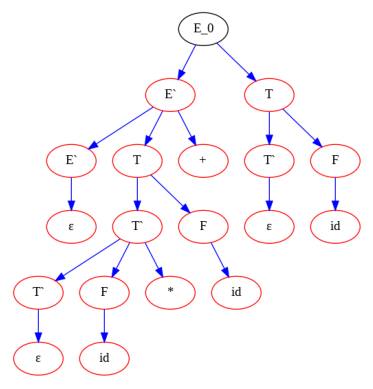

In [60]:
print("\nTree Left-Most Derivation:\n")
left_most_derivation_picture(inpg, p_table, inp_str)